In [1]:
import pandas as pd                                                  # see below for install instruction
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

#### Read Data

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

wiki = pd.read_csv('people_wiki.csv')
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json', typ='series', orient='records')

We need to normalize data first as Euclidean distance can be a poor metric of similarity between documents

In [5]:
tf_idf = normalize(tf_idf)

#### Implement K-mean

In [6]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

#### Check Points

In [7]:
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


In [24]:
dist = pairwise_distances(tf_idf, tf_idf[0:3,:], metric='euclidean')

In [25]:
if np.allclose(dist[430, 1], pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [39]:
distances = dist
closest_cluster = np.argmin(dist, axis=1)

In [40]:
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [43]:
cluster_assignment = closest_cluster

In [44]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [45]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [46]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


#### Toy Example

In [47]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [48]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment )  # prints [0 1 0]

[0 1 0]


In [49]:
print(data[cluster_assignment==1])

[[ 0.  0.  0.]]


In [50]:
print(data[cluster_assignment==0])

[[ 1.  2.  0.]
 [ 2.  2.  0.]]


In [51]:
print(data[cluster_assignment==0].mean(axis=0))

[ 1.5  2.   0. ]


In [54]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [55]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


#### Assessing convergence

In [56]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [58]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
            
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))
                
         # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

#### Plotting convergence metric



In [59]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

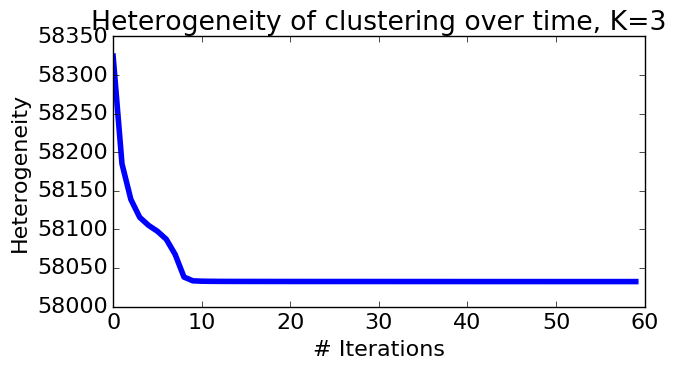

In [60]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

##### Quiz Question. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.

True

##### Quiz Question. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

k-means algorithm got stuck in a bad local minimum<br>
There is a bug in the k-means code<br>
All data points consist of exact duplicates<br>
Nothing is wrong. The objective should generally go down sooner or later.<br>
<br>

k-means algorithm got stuck in a bad local minimum<br>


##### Quiz Question. Which of the cluster contains the greatest number of data points in the end? Hint: Use np.bincount() to count occurrences of each cluster label.

In [62]:
np.argmax(np.bincount(cluster_assignment))

2

#### K-mean gets stuck in a local minimum

In [68]:
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}, max_cluster={2:06}'.format(seed, heterogeneity[seed], np.bincount(cluster_assignment).max()))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442, max_cluster=018047
seed=020000, heterogeneity=57533.20100, max_cluster=015779
seed=040000, heterogeneity=57512.69257, max_cluster=018132
seed=060000, heterogeneity=57466.97925, max_cluster=017900
seed=080000, heterogeneity=57494.92990, max_cluster=017582
seed=100000, heterogeneity=57484.42210, max_cluster=016969
seed=120000, heterogeneity=57554.62410, max_cluster=016481
464.4702959060669


#### Quiz Question. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?

15779 and 18132

K-mean++

In [69]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [70]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
609.5246357917786


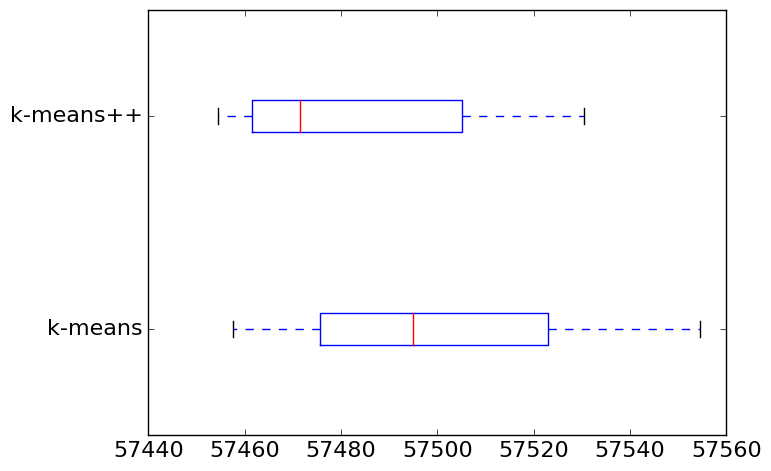

In [77]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [78]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
                
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=verbose)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
            
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

#### Effect of K

In [79]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

2
10
25
50
100


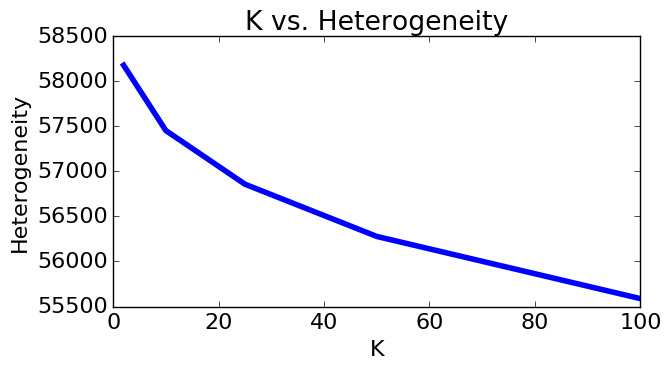

In [81]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [102]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:d}:{1:.3f}'.format(map_index_to_word['category'], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.loc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.loc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [103]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0    
546431:0.025
546431:0.017
546431:0.012
546431:0.011
546431:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                  